Критерии и Структура Проекта
Презентация

Название проекта: Четкое, отражающее суть решаемой задачи

Цель проекта: Конечный желаемый результат. Что вы хотите достичь? (Например, "Разработать модель МО", которая с точностью выше 90% предсказывает уход клиента.)

Задачи проекта: Конкретные шаги для достижения цели. Что нужно сделать? (Например: 
1. Собрать и изучить датасет.
2. Очистить и подготовить данные.
3. Обучить три различные модели.
4. Сравнить их и выбрать лучшую.)

Актуальность: Объяснение, почему этот проект важен для бизнеса, науки или общества. Какую проблему он решает? (Например: Снижение оттока клиентов экономит компании миллионы, делая проект экономически актуальным.)

Датасет (Dataset):

    • Источник данных (Kaggle, собственный сбор, открытые API).
    • Краткое описание набора данных (количество строк, столбцов, типы данных).
    • Ключевые переменные и их природа.
Препроцессинг (Preprocessing) и EDA:

    • Очистка данных: Обработка пропущенных значений (импутация, удаление).
    • Обработка выбросов: Методы их обнаружения и устранения.
    • Кодирование категориальных признаков: Использование One-Hot Encoding, Label Encoding или других методов.
    • Масштабирование/Нормализация: Применение StandardScaler или MinMaxScaler.
    • Инженерия признаков (Feature Engineering): Создание новых признаков, если применимо.
    • Визуализация EDA: Ключевые графики и выводы, которые помогли принять решение по подготовке данных.
Архитектура модели:

    • Выбранные типы моделей (например, Логистическая регрессия, Random Forest, XGBoost, CNN или RNN).
    • Почему именно эти модели выбраны для данной задачи?
    • Для нейронных сетей: описание слоев, функций активации, количества параметров.
Использованные методы:

    • Разделение данных: Описание соотношения для обучающей, валидационной и тестовой выборок.
    • Оптимизаторы и функции потерь: Adam, SGD, MSE, Cross-Entropy и т.д.
    • Кросс-валидация: Если использовалась (например, K-Fold).
    • Подбор гиперпараметров: Методы (Grid Search, Random Search, Bayesian Optimization).
Ключевые метрики (Критерии оценивания):

    • Определение целевой метрики (например, Accuracy, Precision, Recall, F1-Score, ROC AUC).
    • Объяснение, почему именно эта метрика важна для бизнес-задачи (например, для обнаружения мошенничества важнее высокий Recall, чем Accuracy).
Сравнение моделей (если использовались несколько):

    • Сводная таблица с результатами всех протестированных моделей по ключевым метрикам.
    • Обоснование выбора лучшей модели.
Визуализация результатов:

    • Матрица ошибок (Confusion Matrix): Обязательна для задач классификации.
    • ROC-кривая и AUC: Для оценки способности модели различать классы.
    • Feature Importance: График, показывающий, какие признаки оказали наибольшее влияние на предсказания.
Выводы:

    • Финальная точность выбранной модели на тестовом наборе.
    • Достигнута ли первоначальная Цель проекта?
Показ "Приложения" (Deployment):

    • Если проект был развернут, даже локально (например, с помощью Streamlit или Flask), покажите, как это выглядит и работает.
Полный код (GitHub/Notebook):

    • Весь рабочий код проекта должен быть структурирован и доступен (например, в публичном репозитории GitHub или в виде Jupyter Notebook).
    • Код должен быть задокументирован (комментарии) и воспроизводим (включая файл requirements.txt).


In [1]:
import torch
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA: True
GPU: NVIDIA GeForce GTX 1050


In [51]:
import os
import glob
import hashlib
import random
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.optim as optim
from torchvision import models

In [6]:
dataset_root = "stanford_dogs"
images_dir = os.path.join(dataset_root, "Images")
annotations_dir = os.path.join(dataset_root, "Annotation")

# dataset info
class_folders = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])

summary = []
for cls in class_folders:
    img_paths = glob.glob(os.path.join(images_dir, cls, "*.jpg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.jpeg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.png"))
    summary.append({"class_folder": cls, "n_images": len(img_paths), "sample_image": img_paths[0] if img_paths else None})

df = pd.DataFrame(summary)
df = df.sort_values("n_images", ascending=False).reset_index(drop=True)

print("Classes with num of imgs")
print(df.head(50).to_string(index=False))

# 
def hash_image(path):
    try:
        with open(path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

all_image_paths = []
for cls in class_folders:
    all_image_paths.extend(glob.glob(os.path.join(images_dir, cls, "*.jpg")) +
                           glob.glob(os.path.join(images_dir, cls, "*.jpeg")) +
                           glob.glob(os.path.join(images_dir, cls, "*.png")))

print("\nDuplicate handling")
hashes = {}
duplicates = []
for path in all_image_paths:
    h = hash_image(path)
    if h is None:
        continue
    if h in hashes:
        duplicates.append((path, hashes[h]))
    else:
        hashes[h] = path

print(f"Num of duplicates: {len(duplicates)}")


Classes with num of imgs
                  class_folder  n_images                                                           sample_image
         n02085936-Maltese_dog       252          stanford_dogs/Images/n02085936-Maltese_dog/n02085936_4070.jpg
        n02088094-Afghan_hound       239         stanford_dogs/Images/n02088094-Afghan_hound/n02088094_5488.jpg
  n02092002-Scottish_deerhound       232  stanford_dogs/Images/n02092002-Scottish_deerhound/n02092002_12977.jpg
          n02112018-Pomeranian       219           stanford_dogs/Images/n02112018-Pomeranian/n02112018_6098.jpg
n02107683-Bernese_mountain_dog       218 stanford_dogs/Images/n02107683-Bernese_mountain_dog/n02107683_3655.jpg
             n02111889-Samoyed       218             stanford_dogs/Images/n02111889-Samoyed/n02111889_17827.jpg
     n02090721-Irish_wolfhound       218      stanford_dogs/Images/n02090721-Irish_wolfhound/n02090721_2270.jpg
            n02086240-Shih-Tzu       214             stanford_dogs/Images/n0208


=== Handling duplicates ===
Num of duplicates: 89
All duplicates have been moved to stanford_dogs/duplicates

=== Dataset summary after duplicate handling ===
                  class_folder  n_images
         n02085936-Maltese_dog       252
        n02088094-Afghan_hound       239
  n02092002-Scottish_deerhound       229
          n02112018-Pomeranian       219
n02107683-Bernese_mountain_dog       218
             n02111889-Samoyed       218
     n02090721-Irish_wolfhound       218
            n02086240-Shih-Tzu       214
      n02111500-Great_Pyrenees       213
            n02111129-Leonberg       210
             n02110806-basenji       209
     n02097474-Tibetan_terrier       205
            n02096051-Airedale       202
         n02108000-EntleBucher       201
                 n02110958-pug       200
              n02091831-Saluki       199
    n02095889-Sealyham_terrier       199
               n02096177-cairn       197
  n02091467-Norwegian_elkhound       196
  n02096294-Australi

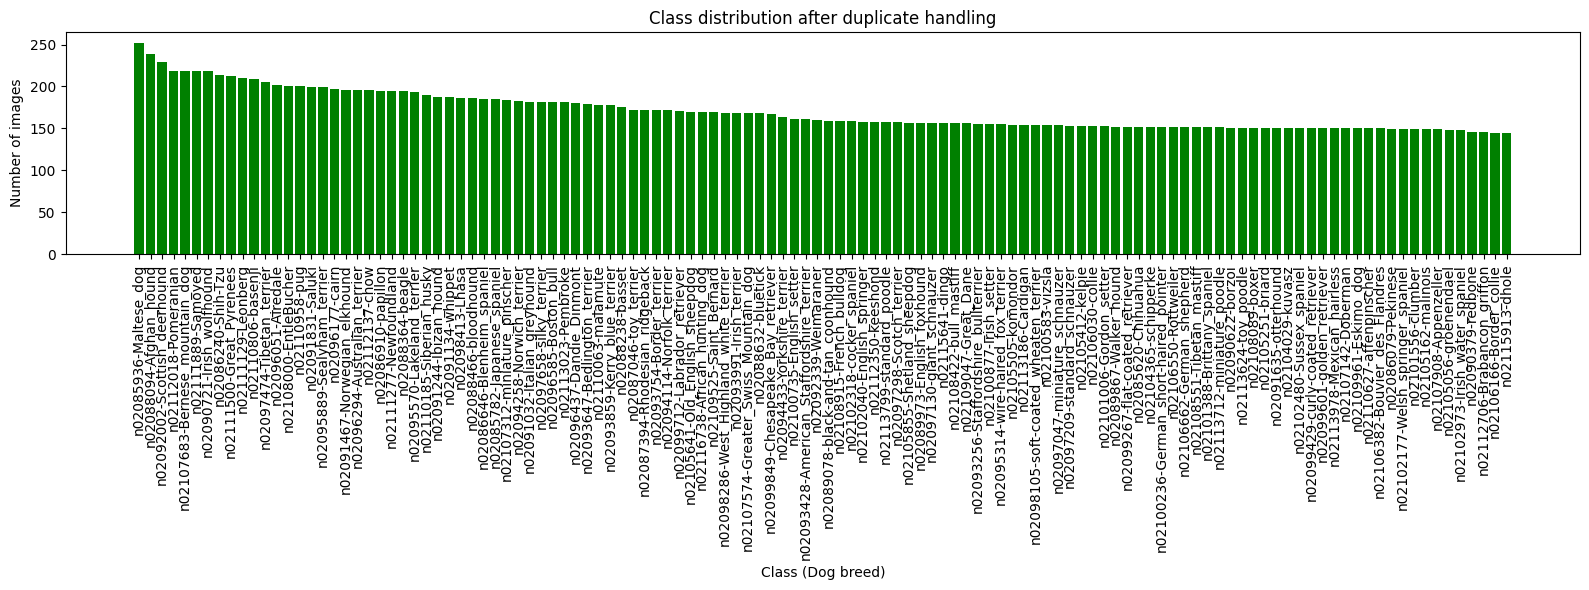

In [9]:
# duplicate Handling
duplicates_folder = os.path.join(dataset_root, "duplicates")
os.makedirs(duplicates_folder, exist_ok=True)

print("\n=== Handling duplicates ===")
print(f"Num of duplicates: {len(duplicates)}")

# move duplicate files to duplicates_folder
for dup_path, original_path in duplicates:
    try:
        # keep original file, move duplicate
        dst_path = os.path.join(duplicates_folder, os.path.basename(dup_path))
        shutil.move(dup_path, dst_path)
    except Exception as e:
        print(f"Error moving {dup_path}: {e}")

print(f"All duplicates have been moved to {duplicates_folder}")

# recount images per class
summary_clean = []
for cls in class_folders:
    img_paths = glob.glob(os.path.join(images_dir, cls, "*.jpg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.jpeg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.png"))
    summary_clean.append({"class_folder": cls, "n_images": len(img_paths)})

df_clean = pd.DataFrame(summary_clean).sort_values("n_images", ascending=False).reset_index(drop=True)
print("\n=== Dataset summary after duplicate handling ===")
print(df_clean.head(50).to_string(index=False))

# visualization after cleanup
plt.figure(figsize=(16,6))
plt.bar(df_clean['class_folder'], df_clean['n_images'], color='green')
plt.xticks(rotation=90)
plt.xlabel("Class (Dog breed)")
plt.ylabel("Number of images")
plt.title("Class distribution after duplicate handling")
plt.tight_layout()
plt.show()

## Pretrained model mobilenet_v2

In [43]:
# parameters
img_size = 64
batch_size = 8
accum_steps = 4
max_per_class = 50
dataset_root = "stanford_dogs"
images_dir = os.path.join(dataset_root, "Images")

# transformations, augmentation, sintetic distortion
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# custom dataset
class StanfordDogsDataset(Dataset):
    def __init__(self, images, labels,class_to_idx=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_to_idx = class_to_idx 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]



# subset dataset, length of 6000
subset_images, subset_labels, class_to_idx = [], [], {}
classes = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
for idx, cls in enumerate(classes):
    class_to_idx[cls] = idx
    img_paths = glob.glob(os.path.join(images_dir, cls, "*.jpg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.jpeg")) + \
                glob.glob(os.path.join(images_dir, cls, "*.png"))
    subset_images.extend(img_paths[:max_per_class])
    subset_labels.extend([idx]*len(img_paths[:max_per_class]))

# shuffle subset
perm = np.random.permutation(len(subset_images))
subset_images = [subset_images[i] for i in perm]
subset_labels = [subset_labels[i] for i in perm]

dataset = StanfordDogsDataset(subset_images, subset_labels, class_to_idx=class_to_idx, transform=transform_train)
labels_arr = np.array(subset_labels)
class_sample_count = np.array([sum(labels_arr == t) for t in np.unique(labels_arr)])
weights = 1. / class_sample_count
samples_weight = weights[labels_arr]
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
# DataLoader
dataset_test = StanfordDogsDataset(subset_images, subset_labels, class_to_idx=class_to_idx, transform=transform_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Number of test batches: {len(test_loader)}\nNumber of training batches: {len(train_loader)}")

Number of test batches: 750
Number of training batches: 750


/home/lb/jupyterlab-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lb/jupyterlab-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


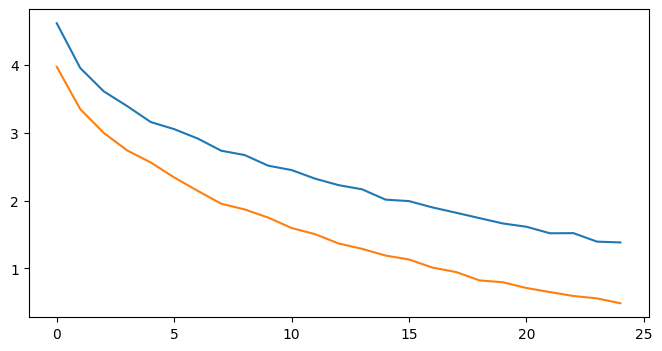

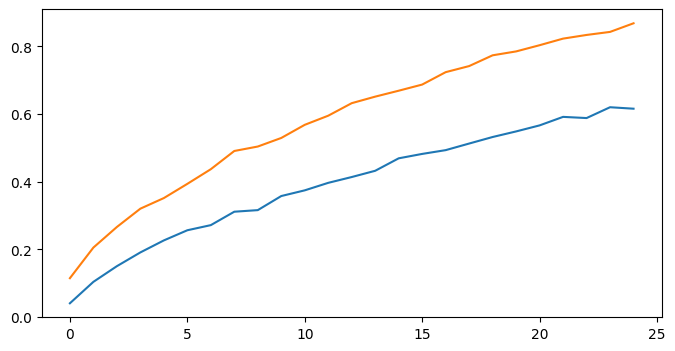

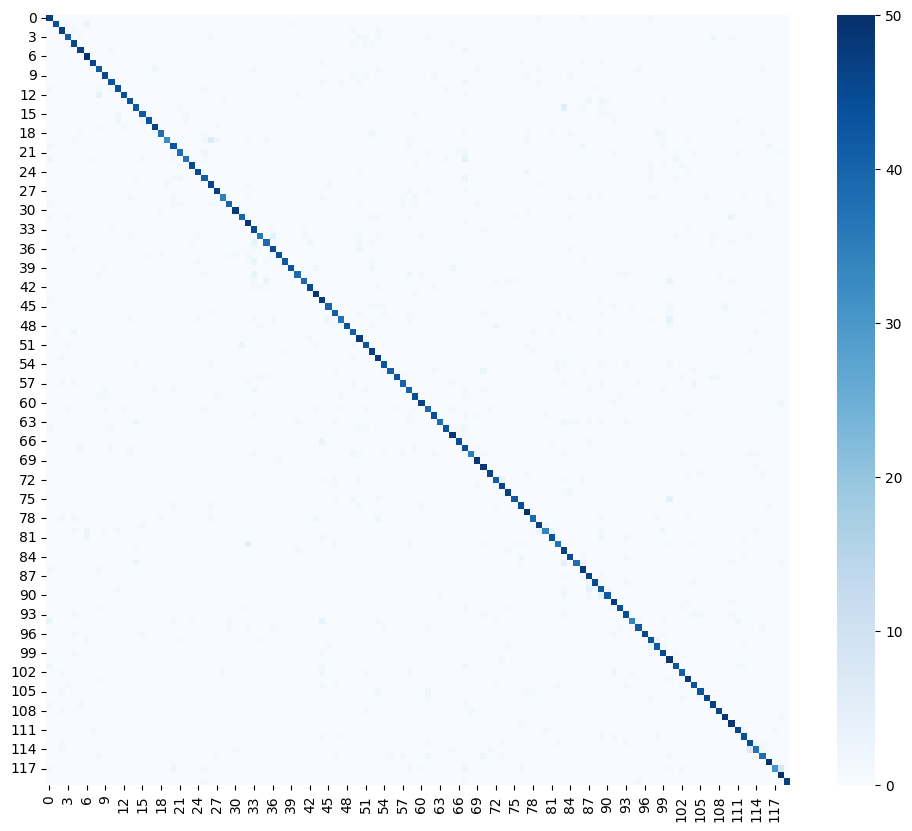

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.75      0.94      0.83        50
              n02085782-Japanese_spaniel       0.98      0.88      0.93        50
                   n02085936-Maltese_dog       0.85      0.94      0.90        50
                      n02086079-Pekinese       0.87      0.82      0.85        50
                      n02086240-Shih-Tzu       0.81      0.92      0.86        50
              n02086646-Blenheim_spaniel       0.90      0.94      0.92        50
                      n02086910-papillon       0.85      1.00      0.92        50
                   n02087046-toy_terrier       0.96      0.92      0.94        50
           n02087394-Rhodesian_ridgeback       0.78      0.84      0.81        50
                  n02088094-Afghan_hound       0.90      0.90      0.90        50
                        n02088238-basset       0.90      0.86      0.88        50
               

In [46]:
# device = torch.device("cpu")
torch.cuda.empty_cache()

# model resnet pretrained
model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_to_idx))
model = model.to(device)

# fine tuning, defrost 4 blocks
for param in model.features[-4:].parameters():
    param.requires_grad = True

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
# 25 epochs, training, testing, metrics for every class
for epoch in range(25):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_losses.append(running_loss / total)
    test_accs.append(correct / total)

plt.figure(figsize=(8,4))
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs)
plt.plot(test_accs)
plt.show()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.show()

report = classification_report(all_labels, all_preds, target_names=list(dataset.class_to_idx.keys()))
print(report)

model.eval()
example = torch.randn(1, 3, img_size, img_size)
traced = torch.jit.trace(model, example)
traced.save("mobilenetv2_stanforddogs_netron.pt")

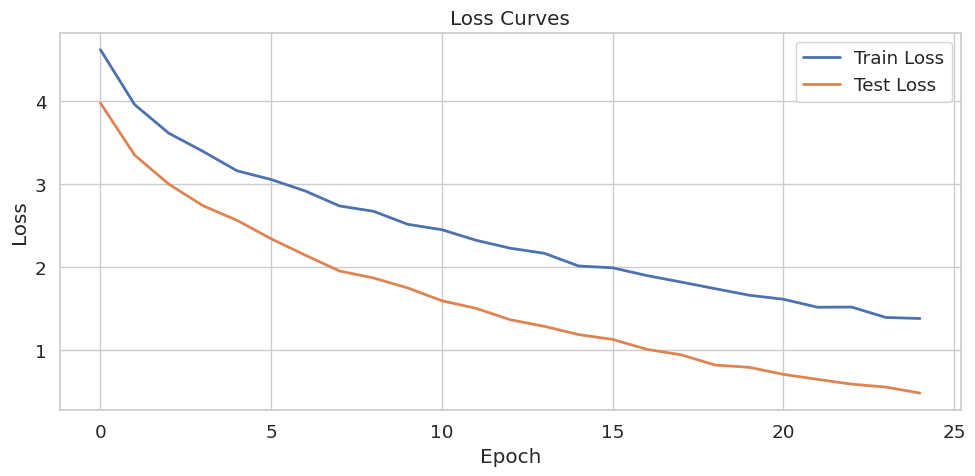

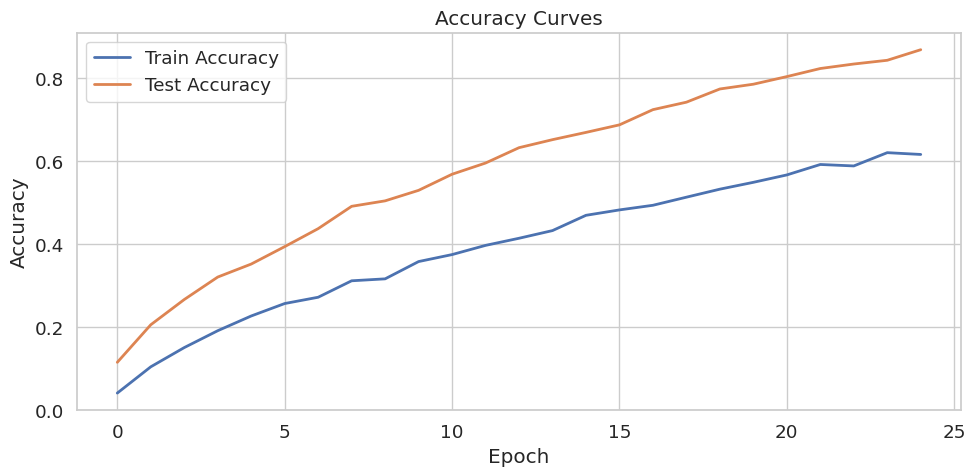

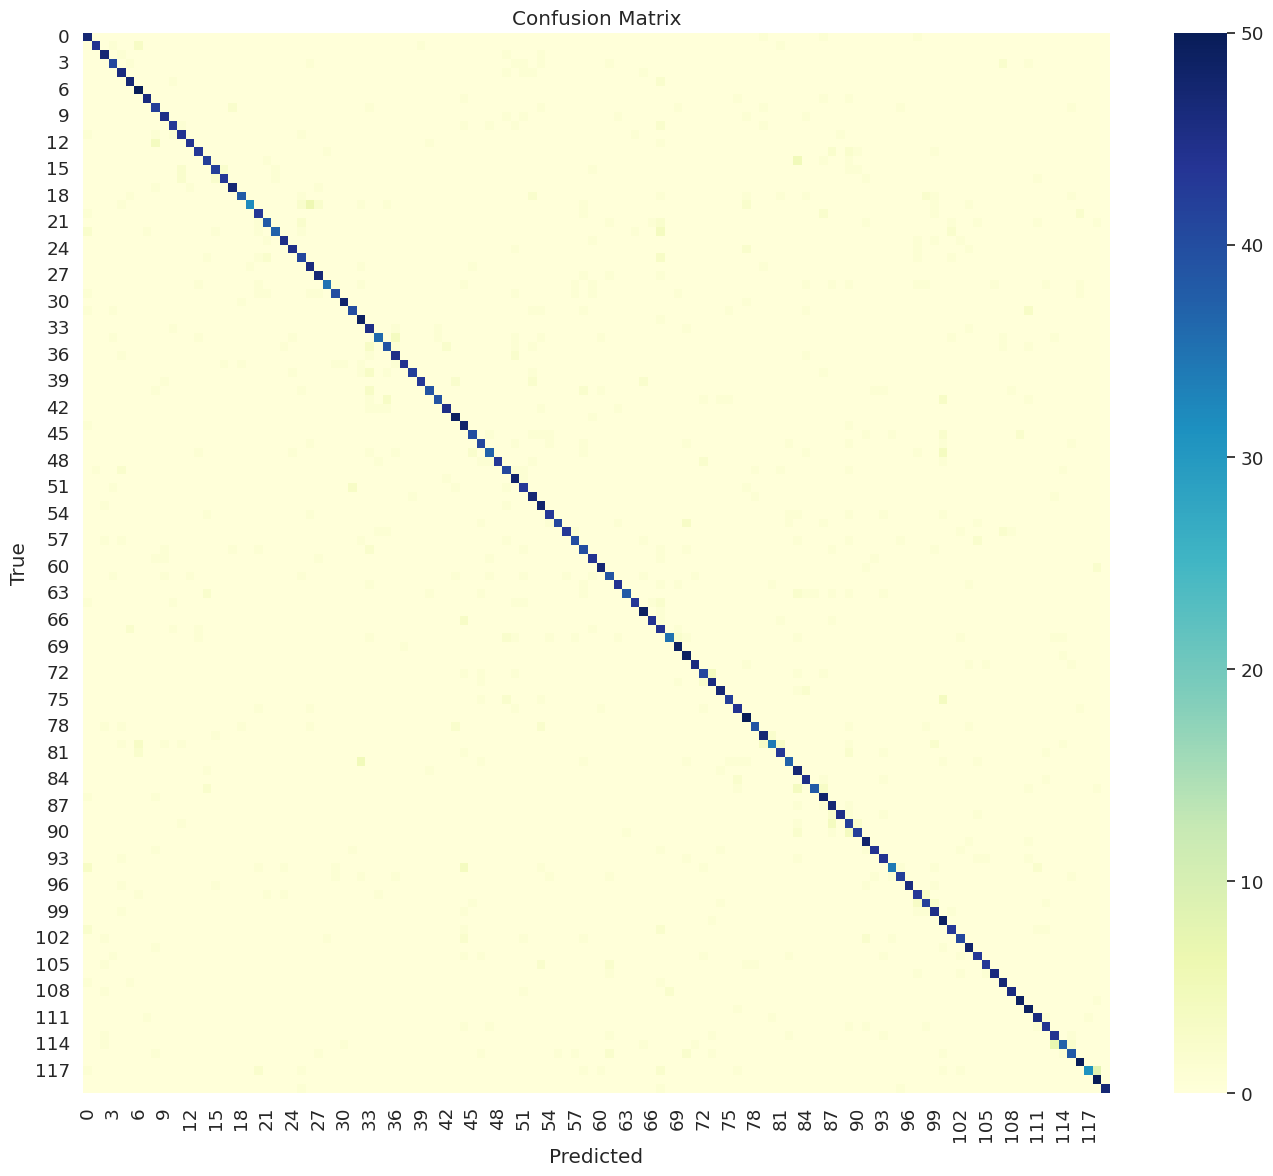

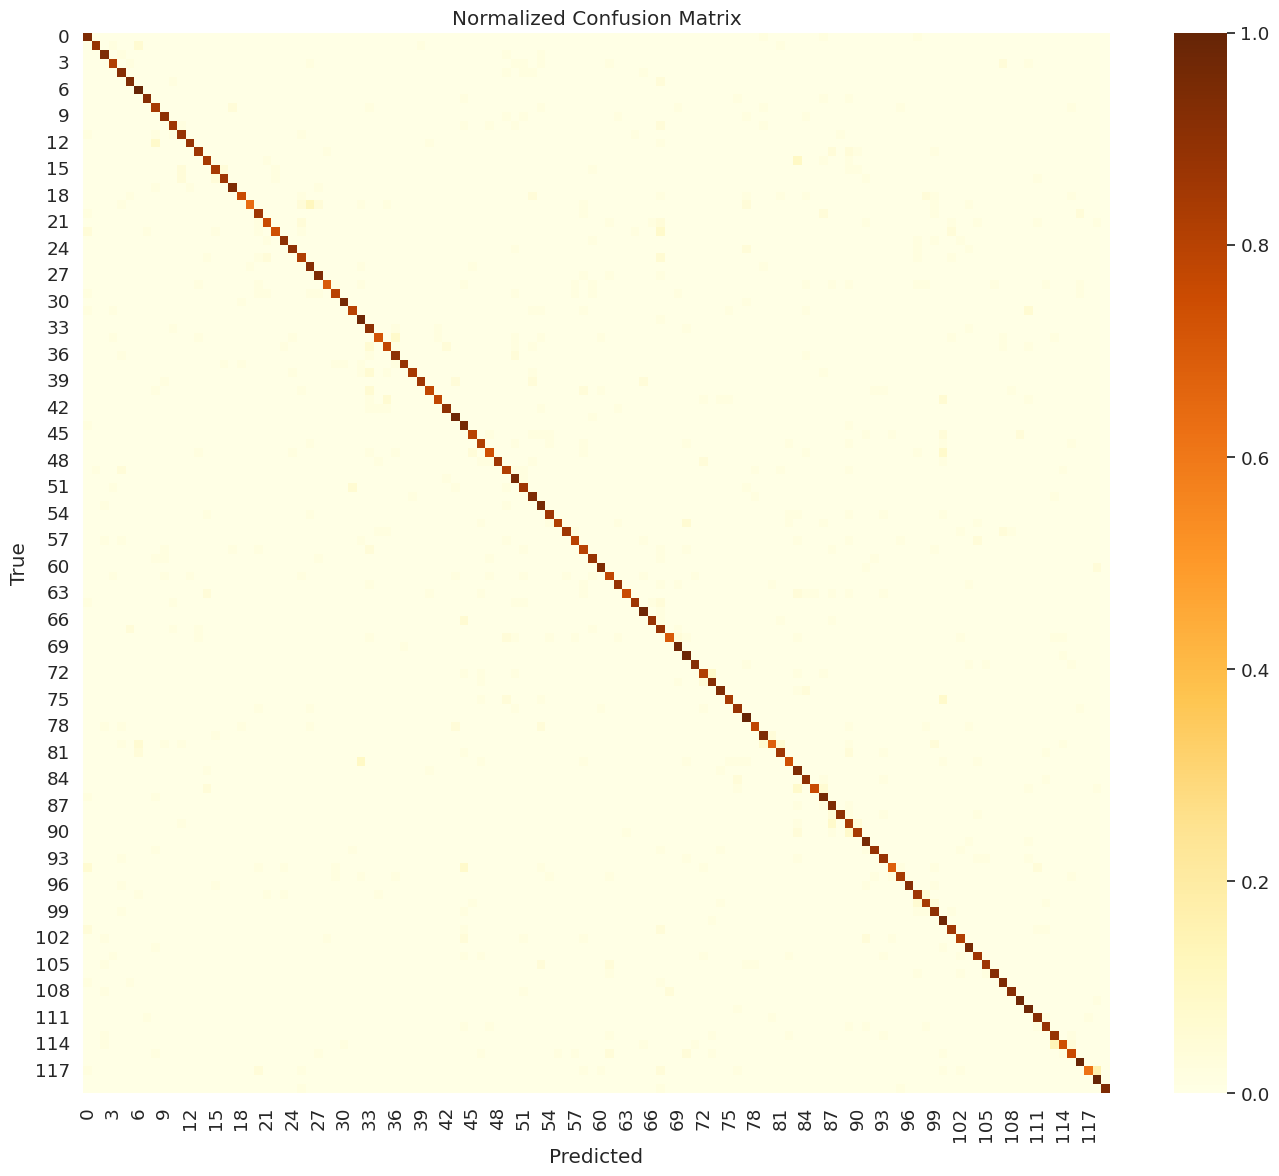

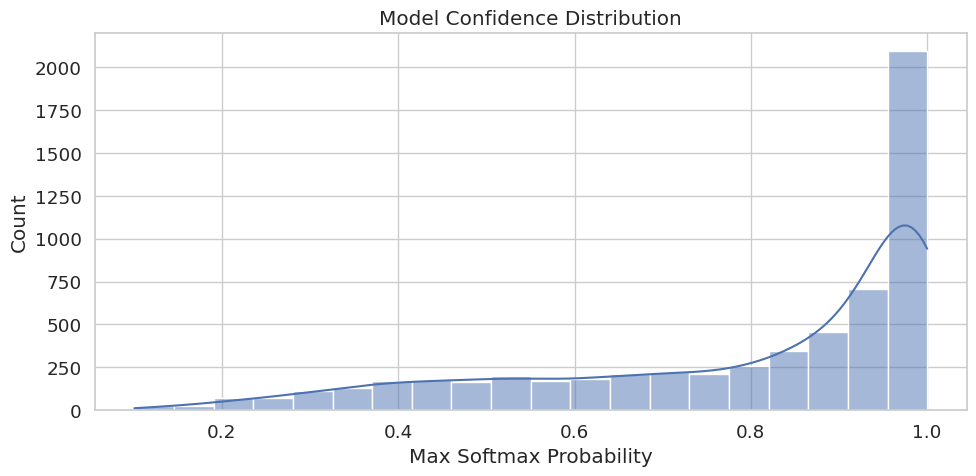

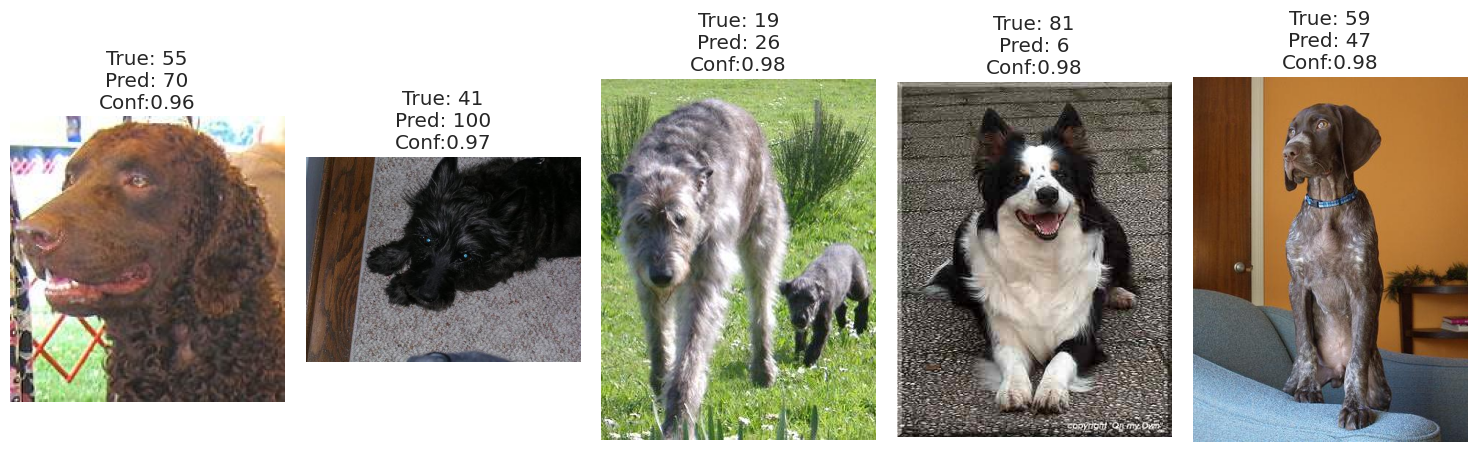


=== Classification Report ===
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.75      0.94      0.83        50
              n02085782-Japanese_spaniel       0.98      0.88      0.93        50
                   n02085936-Maltese_dog       0.85      0.94      0.90        50
                      n02086079-Pekinese       0.87      0.82      0.85        50
                      n02086240-Shih-Tzu       0.81      0.92      0.86        50
              n02086646-Blenheim_spaniel       0.90      0.94      0.92        50
                      n02086910-papillon       0.85      1.00      0.92        50
                   n02087046-toy_terrier       0.96      0.92      0.94        50
           n02087394-Rhodesian_ridgeback       0.78      0.84      0.81        50
                  n02088094-Afghan_hound       0.90      0.90      0.90        50
                        n02088238-basset       0.90      0.86     

In [47]:
sns.set(style="whitegrid", font_scale=1.2)

# loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(test_losses, label="Test Loss", linewidth=2)
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

#accuracy curves
plt.figure(figsize=(10,5))
plt.plot(train_accs, label="Train Accuracy", linewidth=2)
plt.plot(test_accs, label="Test Accuracy", linewidth=2)
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14,12))
sns.heatmap(cm, cmap="YlGnBu", square=False, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#normalized confusion matrix
plt.figure(figsize=(14,12))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap="YlOrBr", square=False)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#distribution of model confidence
probs = []
model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        p = torch.softmax(out, dim=1).max(dim=1)[0]
        probs.extend(p.cpu().numpy())

plt.figure(figsize=(10,5))
sns.histplot(probs, bins=20, kde=True)
plt.title("Model Confidence Distribution")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Show top-5 worst predictions (high confidence but wrong)
wrong_images = []
wrong_true = []
wrong_pred = []
wrong_conf = []

model.eval()
with torch.no_grad():
    for img_path, true_label in zip(subset_images, subset_labels):
        img = Image.open(img_path).convert("RGB")
        t = transform_test(img).unsqueeze(0).to(device)
        out = model(t)
        p = torch.softmax(out, dim=1)
        conf, pred = p.max(1)

        if pred.item() != true_label:
            wrong_images.append(img_path)
            wrong_true.append(true_label)
            wrong_pred.append(pred.item())
            wrong_conf.append(conf.item())

# wrong confidence
worst_idx = np.argsort(wrong_conf)[-5:]

plt.figure(figsize=(15,8))
for i, idx in enumerate(worst_idx, 1):
    plt.subplot(1,5,i)
    plt.imshow(Image.open(wrong_images[idx]))
    plt.title(f"True: {wrong_true[idx]}\nPred: {wrong_pred[idx]}\nConf:{wrong_conf[idx]:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

#classification report
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=list(dataset.class_to_idx.keys())))

In [49]:
!pip install onnx onnxruntime onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 25.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 24.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 7.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 19.1 MB/s eta 0:00:00


In [50]:
torch.onnx.export(model, torch.randn(1, 3, img_size, img_size), "stanford_dogs_CNN.onnx")

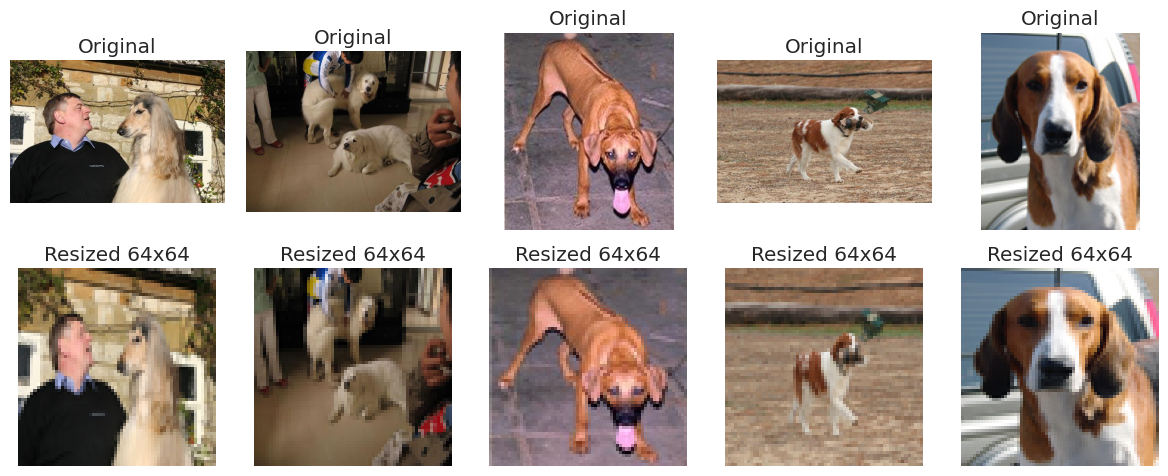

In [52]:
n_samples = 5
sample_indices = random.sample(range(len(subset_images)), n_samples)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(sample_indices):
    img_path = subset_images[idx]
    img_original = Image.open(img_path).convert("RGB")
    img_resized = img_original.resize((img_size, img_size))
    
    # Original
    plt.subplot(2, n_samples, i+1)
    plt.imshow(img_original)
    plt.title("Original")
    plt.axis("off")
    
    # Resized
    plt.subplot(2, n_samples, i+1+n_samples)
    plt.imshow(img_resized)
    plt.title(f"Resized {img_size}x{img_size}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Classic CNN

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self, num_classes=120):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*256, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


num_classes = len(class_to_idx)
cnn_model = CNN(num_classes=num_classes).to(device)

cnn_critetion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)

# Early stopping 
patience = 5
best_acc_cnn = 0
trigger_times_cnn = 0

cnn_train_losses, cnn_test_losses = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(25):
    cnn_model.train()
    running_loss, correct, total = 0,0,0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        cnn_optimizer.zero_grad()
        outputs = cnn_model(imgs)
        loss = cnn_critetion(outputs, lbls)
        loss.backward()
        cnn_optimizer.step()

        running_loss += loss.item()*imgs.size(0)
        _, predicted = outputs.max(1)
        total += lbls.size(0)
        correct += predicted.eq(lbls).sum().item()

    cnn_train_losses.append(running_loss/total)
    cnn_train_accs.append(correct/total)

    # test
    cnn_model.eval()
    running_loss, correct, total = 0,0,0
    all_preds, all_lbls = [], []

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = cnn_model(imgs)
            loss = cnn_critetion(outputs, lbls)
            running_loss += loss.item()*imgs.size(0)

            _, predicted = outputs.max(1)
            total += lbls.size(0)
            correct += predicted.eq(lbls).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_lbls.extend(lbls.cpu().numpy())

    cnn_test_losses.append(running_loss/total)
    cnn_test_accs.append(correct/total)

    cnn_all_preds = all_preds
    cnn_all_labels = all_lbls

    print(f"CNN Epoch {epoch+1}/25 | "
          f"Train Loss: {cnn_train_losses[-1]:.4f}  Acc: {cnn_train_accs[-1]:.4f} | "
          f"Test Loss: {cnn_test_losses[-1]:.4f}  Acc: {cnn_test_accs[-1]:.4f}")

CNN Epoch 1/25 | Train Loss: 4.7087  Acc: 0.0237 | Test Loss: 4.5316  Acc: 0.0388
CNN Epoch 2/25 | Train Loss: 4.4288  Acc: 0.0425 | Test Loss: 4.2678  Acc: 0.0532
CNN Epoch 3/25 | Train Loss: 4.2530  Acc: 0.0615 | Test Loss: 4.1246  Acc: 0.0735
CNN Epoch 4/25 | Train Loss: 4.0830  Acc: 0.0780 | Test Loss: 3.9709  Acc: 0.0980
CNN Epoch 5/25 | Train Loss: 3.9967  Acc: 0.0930 | Test Loss: 3.8854  Acc: 0.1085
CNN Epoch 6/25 | Train Loss: 3.8803  Acc: 0.1133 | Test Loss: 3.7086  Acc: 0.1442
CNN Epoch 7/25 | Train Loss: 3.7992  Acc: 0.1223 | Test Loss: 3.5765  Acc: 0.1692
CNN Epoch 8/25 | Train Loss: 3.6992  Acc: 0.1398 | Test Loss: 3.5054  Acc: 0.1787
CNN Epoch 9/25 | Train Loss: 3.6284  Acc: 0.1478 | Test Loss: 3.3799  Acc: 0.2010
CNN Epoch 10/25 | Train Loss: 3.5059  Acc: 0.1690 | Test Loss: 3.3169  Acc: 0.2107
CNN Epoch 11/25 | Train Loss: 3.4166  Acc: 0.1893 | Test Loss: 3.2630  Acc: 0.2195
CNN Epoch 12/25 | Train Loss: 3.3328  Acc: 0.2135 | Test Loss: 3.1536  Acc: 0.2323
CNN Epoch 13/

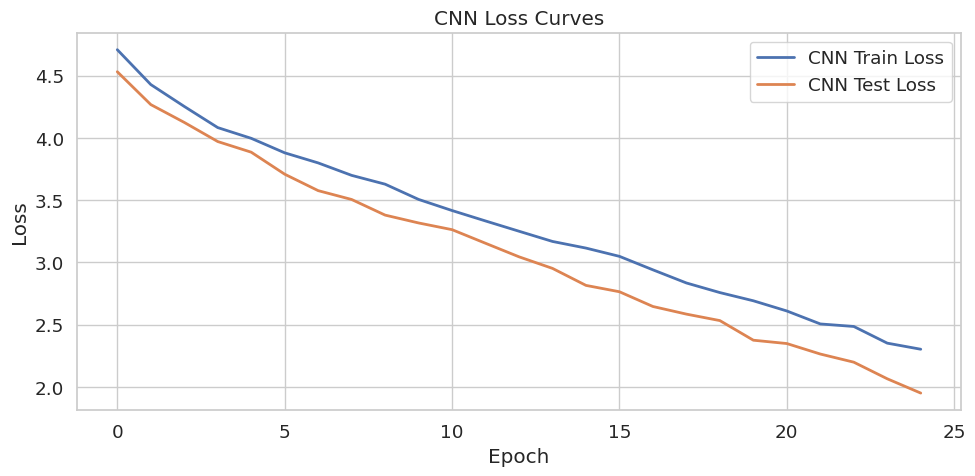

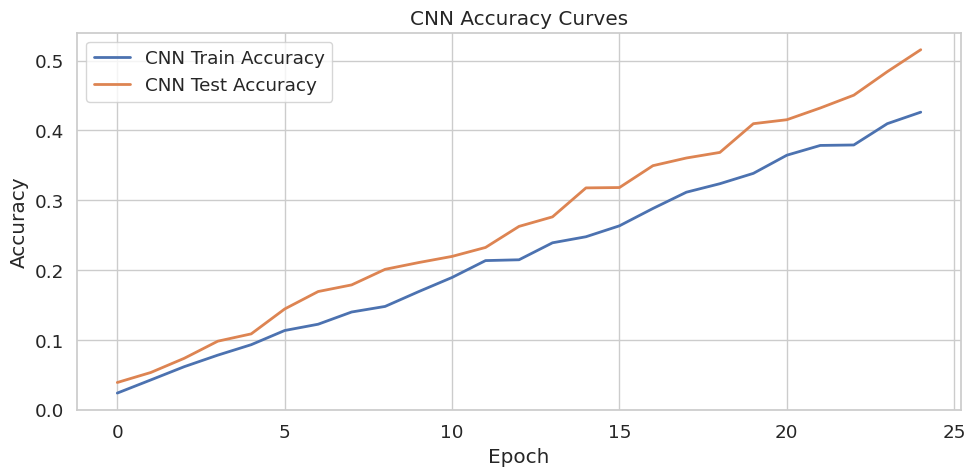

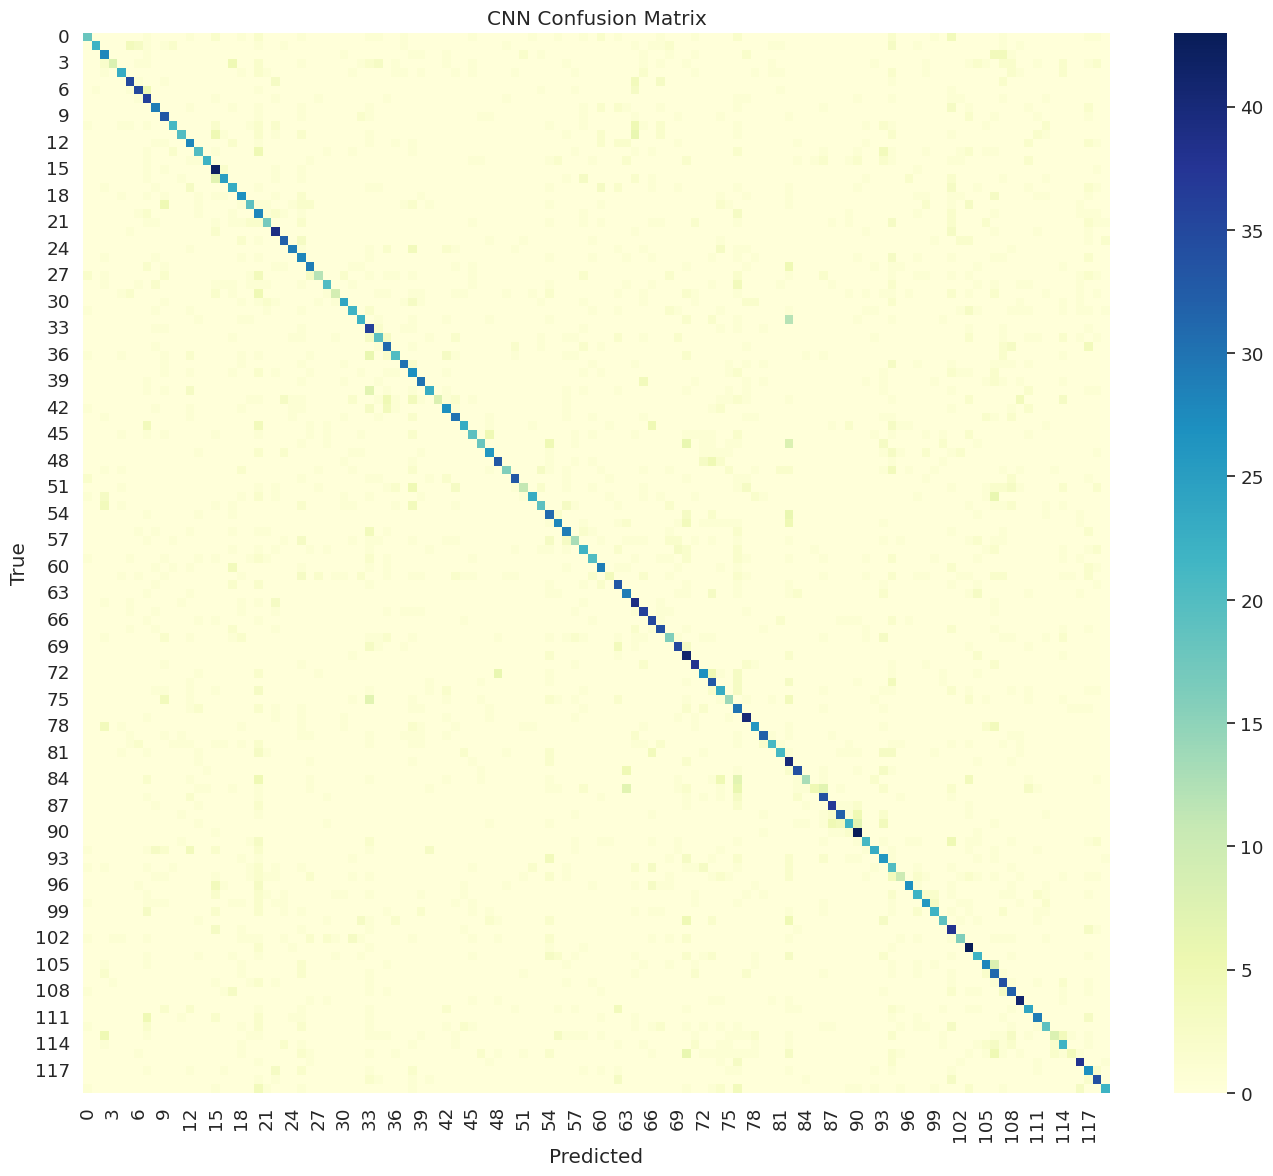

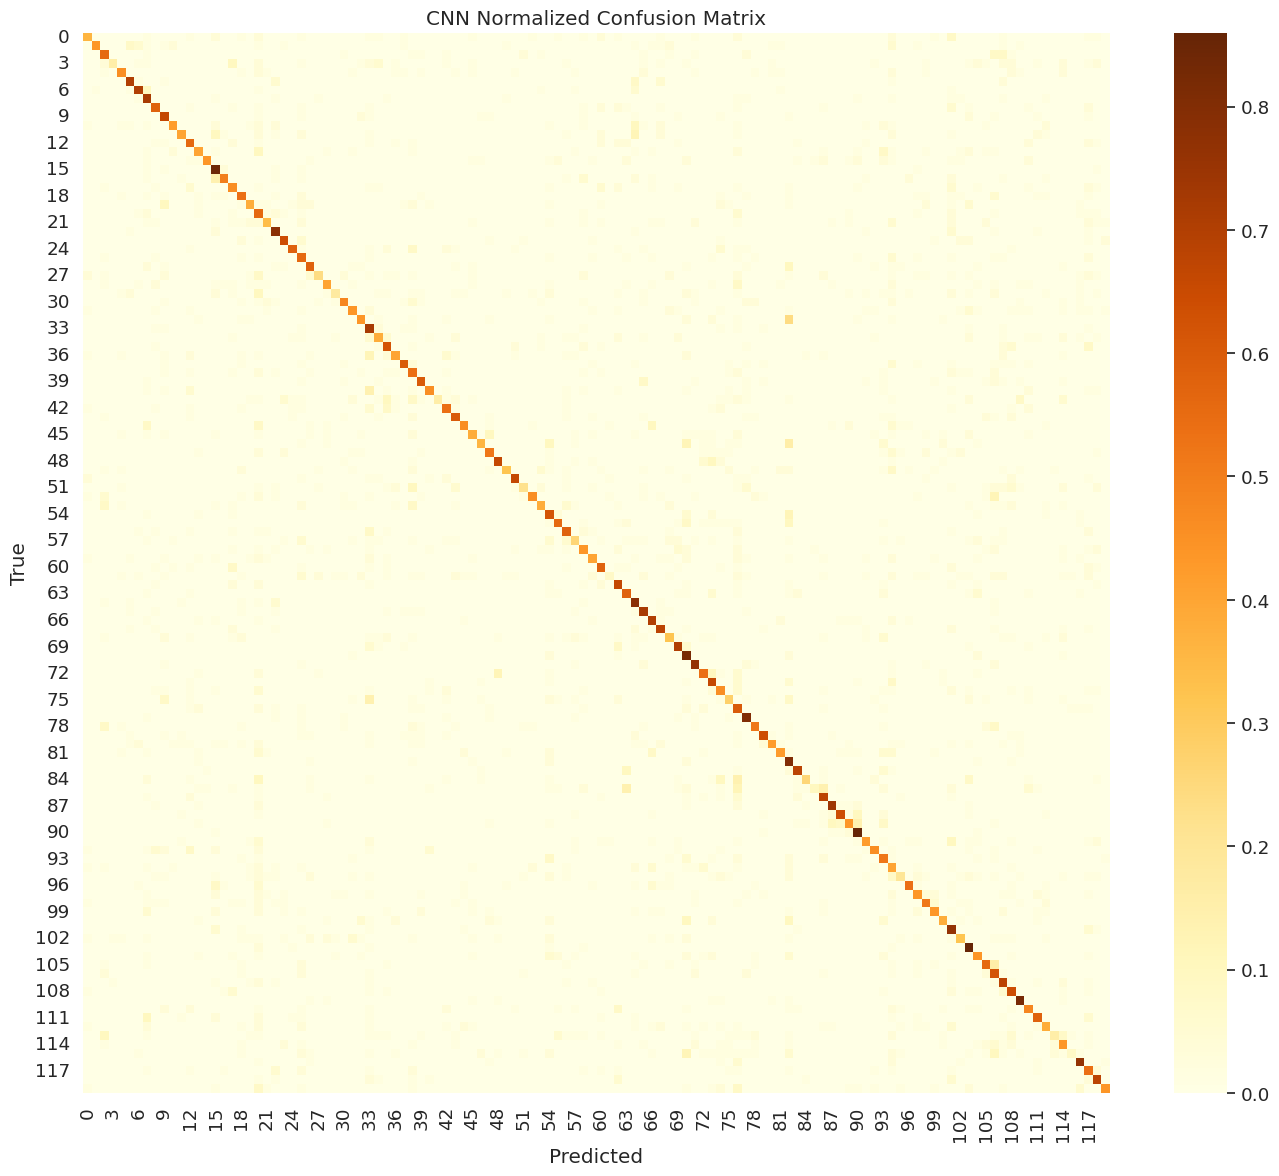

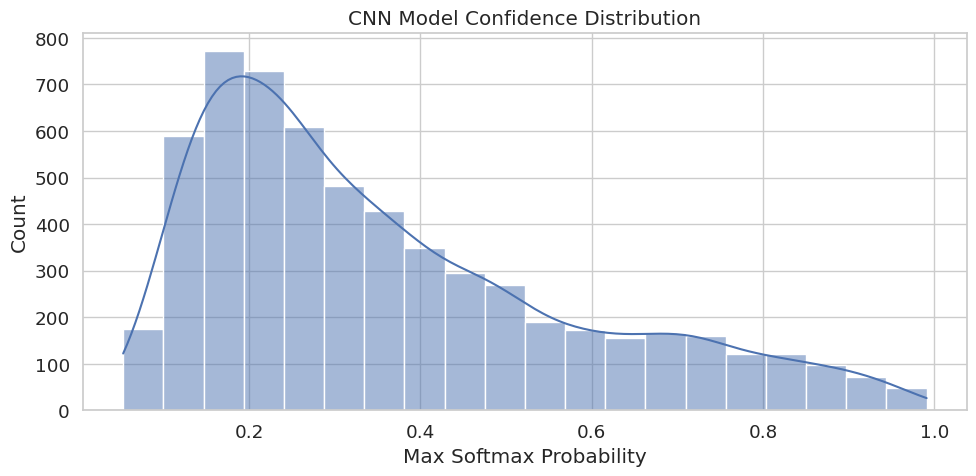

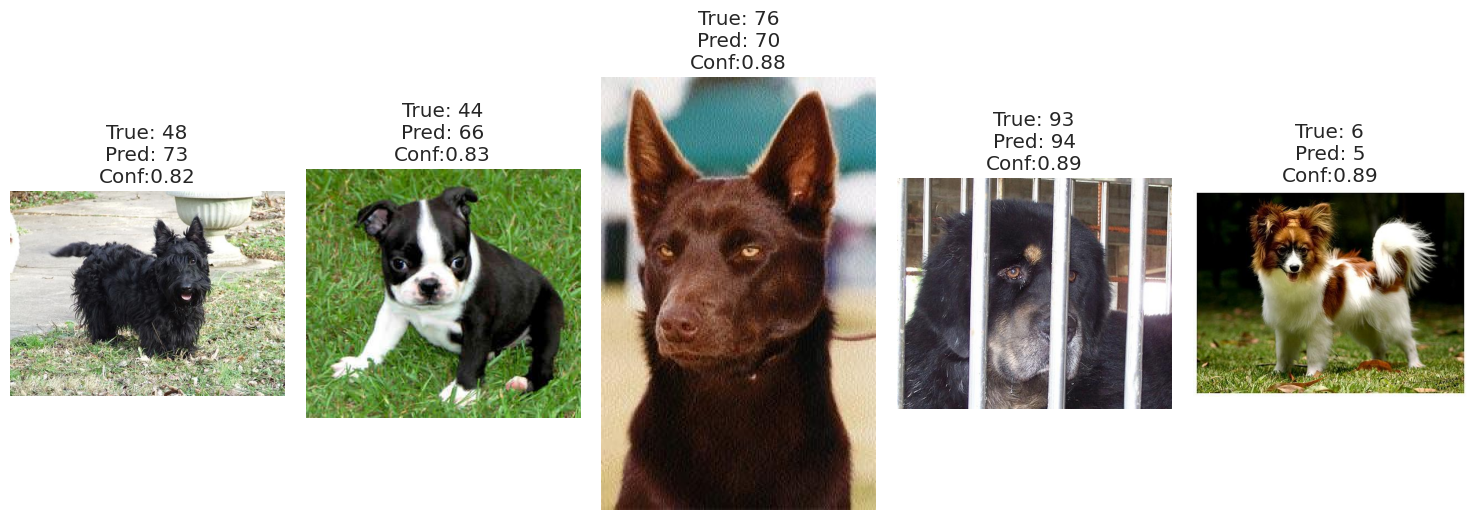


=== Classification Report ===
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.51      0.36      0.42        50
              n02085782-Japanese_spaniel       0.96      0.44      0.60        50
                   n02085936-Maltese_dog       0.47      0.56      0.51        50
                      n02086079-Pekinese       0.80      0.16      0.27        50
                      n02086240-Shih-Tzu       0.66      0.46      0.54        50
              n02086646-Blenheim_spaniel       0.70      0.70      0.70        50
                      n02086910-papillon       0.71      0.70      0.71        50
                   n02087046-toy_terrier       0.40      0.72      0.51        50
           n02087394-Rhodesian_ridgeback       0.57      0.58      0.57        50
                  n02088094-Afghan_hound       0.47      0.66      0.55        50
                        n02088238-basset       0.72      0.42     

In [66]:
sns.set(style="whitegrid", font_scale=1.2)

# loss curves
plt.figure(figsize=(10,5))
plt.plot(cnn_train_losses, label="CNN Train Loss", linewidth=2)
plt.plot(cnn_test_losses, label="CNN Test Loss", linewidth=2)
plt.title("CNN Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# accuracy curves
plt.figure(figsize=(10,5))
plt.plot(cnn_train_accs, label="CNN Train Accuracy", linewidth=2)
plt.plot(cnn_test_accs, label="CNN Test Accuracy", linewidth=2)
plt.title("CNN Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# confusion matrix
cm_cnn = confusion_matrix(cnn_all_labels, cnn_all_preds)
plt.figure(figsize=(14,12))
sns.heatmap(cm_cnn, cmap="YlGnBu", square=False, cbar=True)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# normalized confusion matrix
plt.figure(figsize=(14,12))
sns.heatmap(cm_cnn / cm_cnn.sum(axis=1, keepdims=True), cmap="YlOrBr", square=False)
plt.title("CNN Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# model confidence distribution
probs_cnn = []
cnn_model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        out = cnn_model(imgs)
        p = torch.softmax(out, dim=1).max(dim=1)[0]
        probs_cnn.extend(p.cpu().numpy())

plt.figure(figsize=(10,5))
sns.histplot(probs_cnn, bins=20, kde=True)
plt.title("CNN Model Confidence Distribution")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Top-5 Worst Predictions with Images
wrong_images = []
wrong_true = []
wrong_pred = []
wrong_conf = []

cnn_model.eval()
with torch.no_grad():
    for img_path, true_label in zip(subset_images, subset_labels):
        img = Image.open(img_path).convert("RGB")
        t = transform_test(img).unsqueeze(0).to(device)
        out = cnn_model(t)
        p = torch.softmax(out, dim=1)
        conf, pred = p.max(1)

        if pred.item() != true_label:
            wrong_images.append(img_path)
            wrong_true.append(true_label)
            wrong_pred.append(pred.item())
            wrong_conf.append(conf.item())

worst_idx = np.argsort(wrong_conf)[-5:]

plt.figure(figsize=(15,8))
for i, idx in enumerate(worst_idx, 1):
    plt.subplot(1,5,i)
    plt.imshow(Image.open(wrong_images[idx]))
    plt.title(f"True: {wrong_true[idx]}\nPred: {wrong_pred[idx]}\nConf:{wrong_conf[idx]:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

print("\n=== Classification Report ===")
print(classification_report(cnn_all_labels, cnn_all_preds, target_names=list(dataset.class_to_idx.keys())))


In [73]:
cnn_model.eval()
example = torch.randn(1, 3, 64, 64).to(device)
traced_cnn = torch.jit.trace(cnn_model, example)
traced_cnn.save("cnn_stanforddogs_netron.pt")

torch.onnx.export(
    cnn_model,
    example,
    "cnn_stanforddogs.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

print("Saved: cnn_stanforddogs.onnx")

Saved: cnn_stanforddogs.onnx
